In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

import scipy as sc
from scipy import constants

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
    print("Stamnes' DISORT imported.")
except ImportError:
    disort_is_installed = False
    print("Stamnes' DISORT unavailable. Cached results will be used.")

Stamnes' DISORT imported.


# Table of Contents
* [7a and setup](#7a-and-setup)
* [7b](#7b)
* [7c and new setup](#7c-and-new-setup)
* [7d](#7d)
* [7e](#7e)


# Test Problem 7:  Absorption + Scattering + All Possible Sources, Lambertian and Hapke Surface Reflectivities (One Layer)

These problems thoroughly test our single-layer solver. Results for 7a, b can be compared to Table I of Kylling, A. and K. Stamnes, 1992: Efficient yet accurate solution of the linear transport equation in the presence of internal sources: The exponential-linear-in-depth approximation, *J. Comp. Phys., 102(2)*, 265-276. The intensity field of the upwelling radiation, which can be compared to satellite measurements, is plotted for each subproblem.

# 7a and setup

Internal blackbody emission and low scattering.

**PythonicDISORT**

In [3]:
from PythonicDISORT.subroutines import generate_s_poly_coeffs

In [4]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (medium-thick atmosphere)
omega_arr = 0.1  # Very low scattering
NQuad = 16  # 16 streams (8 quadrature nodes for each hemisphere)
Leg_coeffs_all = 0.05 ** np.arange(NQuad + 1) # Henyey-Greenstein phase function with g = 0.05
mu0 = 0  # No direct beam
I0 = 0  # No direct beam
phi0 = 0  # No direct beam

# Optional (used)
TEMPER = np.array([200, 300])
WVNMLO = 300
WVNMHI = 800
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI) * (1 - omega_arr)

# Optional (unused)
NLeg = None
NFourier = None
b_pos = 0
b_neg = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes = []
use_banded_solver_NLayers = 10
autograd_compatible=False

####################################################################################################

In [5]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    s_poly_coeffs=s_poly_coeffs,
)

**Setup for tests**

In [6]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [7]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 1])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [8]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = True
lamber = False
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = TEMPER
wvnmlo = WVNMLO
wvnmhi = WVNMHI
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [9]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/7a_test.npz")

**Comparisons**

In [10]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.0003609140789819776
Difference ratio = 1.000000042482824

Downward (diffuse) fluxes
Difference = 0.00037085277658377436
Difference ratio = 1.0000000007308605

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 1
Max pointwise difference = 0.0001506712594050441
At tau = 0
Max pointwise difference ratio = 7.523099342785171e-06



**Does the test pass?**

In [11]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/7a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [12]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

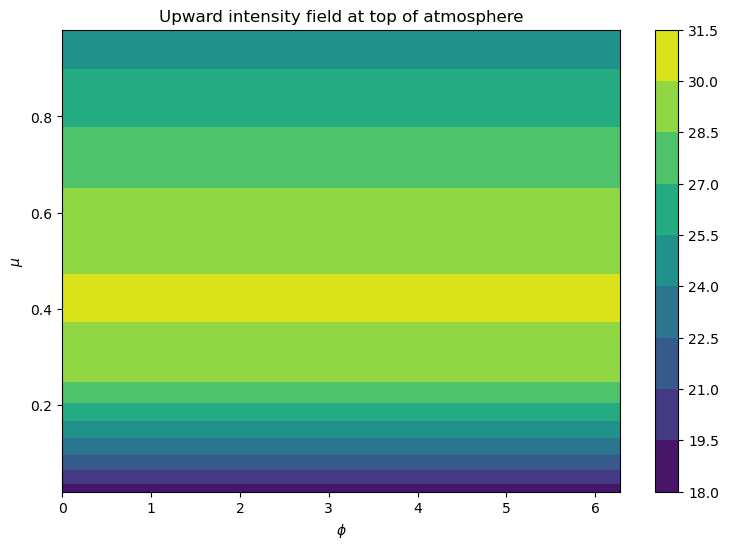

In [13]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)

-------

# 7b

Internal blackbody emission, high scattering and thick atmosphere.

**PythonicDISORT**

In [14]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 100  # One layer of thickness 100 (Very thick atmosphere)
omega_arr = 0.95  # High scattering
NQuad = 16  # 16 streams (8 quadrature nodes for each hemisphere)
Leg_coeffs_all = 0.75 ** np.arange(NQuad + 1) # Henyey-Greenstein phase function with g = 0.75
mu0 = 0  # No direct beam
I0 = 0  # No direct beam
phi0 = 0  # No direct beam

# Optional (used)
TEMPER = np.array([200, 300])
WVNMLO = 2702.99
WVNMHI = 2703.01
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI) * (1 - omega_arr)

# Optional (unused)
NLeg = None
NFourier = None
b_pos = 0
b_neg = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes = []
use_banded_solver_NLayers = 10
autograd_compatible=False

####################################################################################################

In [15]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    s_poly_coeffs=s_poly_coeffs,
)

In [16]:
tau_test_arr = np.array([0, 100])

**Stamnes' DISORT**

In [17]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = True
lamber = False
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = TEMPER
wvnmlo = WVNMLO
wvnmhi = WVNMHI
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [18]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/7b_test.npz")

**Comparisons**

In [19]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 6.454001466676577e-09
Difference ratio = 1.0000000003524094

Downward (diffuse) fluxes
Difference = 1.208869708114702e-07
Difference ratio = 0.005851504923270324

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 100
Max pointwise difference = 4.36438113629516e-08
At tau = 100
Max pointwise difference ratio = 0.00591364096197912



**Does the test pass?**

In [20]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/7b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [21]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

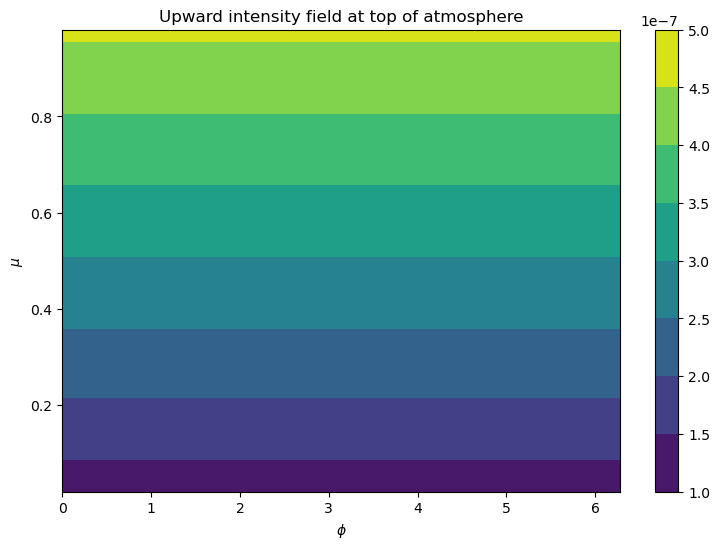

In [22]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
#plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
#plt.legend()

------

# 7c and new setup

Turn on every source.

**PythonicDISORT**

In [23]:
from PythonicDISORT.subroutines import blackbody_contrib_to_BCs
from PythonicDISORT.subroutines import generate_s_poly_coeffs

In [24]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (Medium-thick atmosphere)
omega_arr = 0.5  # Low scattering
NQuad = 12  # 12 streams (6 quadrature nodes for each hemisphere)
Leg_coeffs_all = 0.8 ** np.arange(2 * NQuad) # Henyey-Greenstein phase function with g = 0.8
mu0 = 0.5  # Cosine of solar zenith angle (directly downwards)
I0 = 200  # Intensity of direct beam
phi0 = 0  # Azimuthal angle of direct beam

# Optional (used)
TEMPER = np.array([300, 200])
WVNMLO = 0
WVNMHI = 80000
BTEMP = 320
TTEMP = 100
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI, epsrel=1e-15) * (1 - omega_arr)
b_pos = blackbody_contrib_to_BCs(BTEMP, WVNMLO, WVNMHI, epsrel=1e-15) # Emissivity 1
b_neg = blackbody_contrib_to_BCs(TTEMP, WVNMLO, WVNMHI, epsrel=1e-15) + 100 # Emissivity 1

f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg = None
NFourier = None
only_flux = False
BDRF_Fourier_modes = []
use_banded_solver_NLayers = 10
autograd_compatible=False

####################################################################################################

In [25]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    s_poly_coeffs=s_poly_coeffs,
    f_arr=f_arr,
    NT_cor=NT_cor,
)

**Setup for tests**

In [26]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [27]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 1])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [28]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = True
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = TEMPER
wvnmlo = WVNMLO
wvnmhi = WVNMHI
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 100
albedo = 0
btemp = BTEMP
ttemp = TTEMP
temis = 1
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [29]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/7c_test.npz")

**Comparisons**

In [30]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.005680822073827585
Difference ratio = 9.554405881946251e-06

Downward (diffuse) fluxes
Difference = 0.0015585893128786665
Difference ratio = 5.172303206114839e-06

Direct (downward) fluxes
Difference = 4.280623855379417e-09
Difference ratio = 3.162976979581489e-10

Intensities

At tau = 1
Max pointwise difference = 0.008105930163637254
At tau = 1
Max pointwise difference ratio = 8.864380022709193e-05



**Does the test pass?**

In [31]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/7c_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [32]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

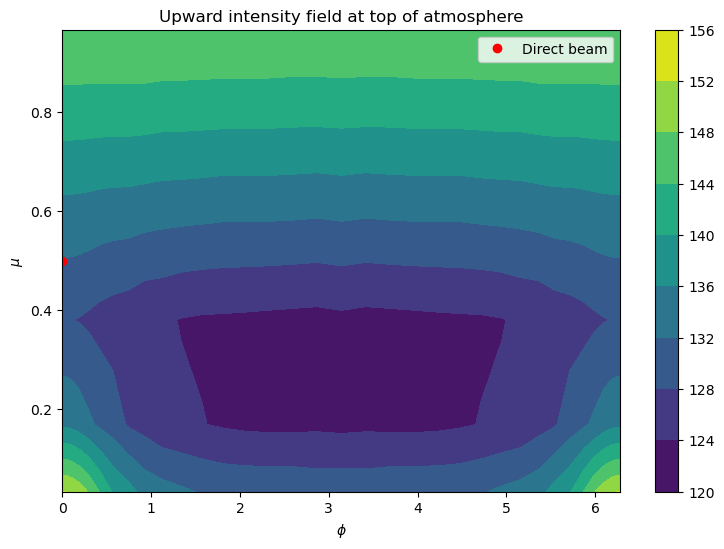

In [33]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

------

# 7d

Every source turned on with conservative Lambertian surface reflection.

**PythonicDISORT**

In [34]:
from PythonicDISORT.subroutines import blackbody_contrib_to_BCs
from PythonicDISORT.subroutines import generate_s_poly_coeffs

In [35]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (Medium-thick atmosphere)
omega_arr = 0.5  # Low scattering
NQuad = 12  # 12 streams (6 quadrature nodes for each hemisphere)
Leg_coeffs_all = 0.8 ** np.arange(2 * NQuad) # Henyey-Greenstein phase function with g = 0.8
mu0 = 0.5  # Cosine of solar zenith angle (directly downwards)
I0 = 200  # Intensity of direct beam
phi0 = 0  # Azimuthal angle of direct beam

# Optional (used)
TEMPER = np.array([300, 200])
WVNMLO = 0
WVNMHI = 80000
BTEMP = 320
TTEMP = 100
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI, epsrel=1e-15) * (1 - omega_arr)
b_neg = blackbody_contrib_to_BCs(TTEMP, WVNMLO, WVNMHI, epsrel=1e-15) + 100 # Emissivity 1
omega_s = 1
BDRF_Fourier_modes=[lambda mu, neg_mup: np.full((len(mu), len(neg_mup)), omega_s)]

f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg = None
NFourier = None
b_pos = 0
only_flux = False
use_banded_solver_NLayers = 10
autograd_compatible=False

####################################################################################################

In [36]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_neg=b_neg,
    s_poly_coeffs=s_poly_coeffs,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    f_arr=f_arr,
    NT_cor=NT_cor,
)

**Stamnes' DISORT**

In [37]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = True
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = TEMPER
wvnmlo = WVNMLO
wvnmhi = WVNMHI
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 100
albedo = omega_s
btemp = BTEMP
ttemp = TTEMP
temis = 1
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [38]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/7d_test.npz")

**Comparisons**

In [39]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.002258723149054731
Difference ratio = 7.226456788570022e-06

Downward (diffuse) fluxes
Difference = 0.0014112028268868926
Difference ratio = 4.831849654115629e-06

Direct (downward) fluxes
Difference = 4.280623855379417e-09
Difference ratio = 3.162976979581489e-10

Intensities

At tau = 1
Max pointwise difference = 0.008072988061485376
At tau = 1
Max pointwise difference ratio = 9.104718902397816e-05



**Does the test pass?**

In [40]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/7d_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [41]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

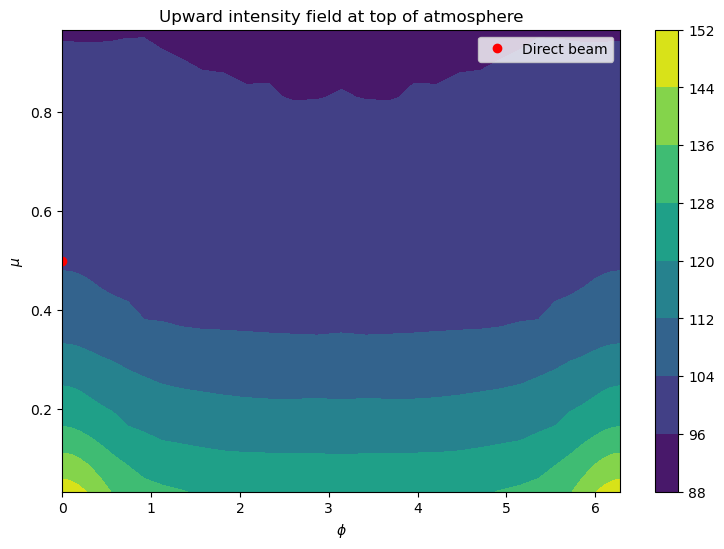

In [42]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

------

# 7e

Every source turned on with Hapke (see [[1, p. 233]](#cite-Hap1993) and [[2, p. 44]](#cite-STWLE2000)) surface reflection. Only flux values are compared.

**PythonicDISORT**

In [43]:
from PythonicDISORT.subroutines import generate_emissivity_from_BDRF
from PythonicDISORT.subroutines import blackbody_contrib_to_BCs
from PythonicDISORT.subroutines import generate_s_poly_coeffs

In [44]:
def Hapke(mu, neg_mup, dphi, B0, HH, W):
    cos_alpha = (mu[:, None] * neg_mup[None, :] - np.sqrt(1 - mu**2)[:, None] * np.sqrt(
        (1 - neg_mup**2)[None, :]
    ) * np.cos(dphi)).clip(min=-1, max=1)
    alpha = np.arccos(cos_alpha)

    P = 1 + cos_alpha / 2
    B = B0 * HH / (HH + np.tan(alpha / 2))

    gamma = np.sqrt(1 - W)
    H0 = ((1 + 2 * neg_mup) / (1 + 2 * neg_mup * gamma))[None, :]
    H = ((1 + 2 * mu) / (1 + 2 * mu * gamma))[:, None]

    return W / 4 / (mu[:, None] + neg_mup[None, :]) * ((1 + B) * P + H0 * H - 1)

In [45]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (Medium-thick atmosphere)
omega_arr = 0.5  # Low scattering
NQuad = 12  # 12 streams (6 quadrature nodes for each hemisphere)
Leg_coeffs_all = 0.8 ** np.arange(NQuad + 1) # Henyey-Greenstein phase function with g = 0.8
mu0 = 0.5  # Cosine of solar zenith angle (directly downwards)
I0 = 200  # Intensity of direct beam
phi0 = 0  # Azimuthal angle of direct beam

# Optional (used)
B0, HH, W = 1, 0.06, 0.6
BDRF_Fourier_modes = [
    lambda mu, neg_mup, m=m: (sc.integrate.quad_vec(
        lambda dphi: Hapke(mu, neg_mup, dphi, B0, HH, W) * np.cos(m * dphi),
        0,
        2 * pi,
    )[0] / ((1 + (m == 0)) * pi))
    for m in range(NQuad)
]
TEMPER = np.array([300, 200])
WVNMLO = 0
WVNMHI = 80000
BTEMP = 320
TTEMP = 100
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI, epsrel=1e-15) * (1 - omega_arr)
# The emissivity of the surface should be consistent with the BDRF 
# in accordance with Kirchoff's law of thermal radiation
emissivity = generate_emissivity_from_BDRF(NQuad // 2, BDRF_Fourier_modes[0])
b_pos = emissivity * blackbody_contrib_to_BCs(BTEMP, WVNMLO, WVNMHI)
b_neg = blackbody_contrib_to_BCs(TTEMP, WVNMLO, WVNMHI, epsrel=1e-15) + 100 # Emissivity 1
only_flux = True

f_arr = Leg_coeffs_all[NQuad]

# Optional (unused)
NLeg = None
NFourier = None
NT_cor = False
use_banded_solver_NLayers = 10
autograd_compatible=False

####################################################################################################

In [46]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0 = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    s_poly_coeffs=s_poly_coeffs,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    only_flux=only_flux,
    f_arr=f_arr,
)

In [47]:
# Load saved results from `DISOTESTAUX.f` of Stamnes' DISORT
results = np.load("Stamnes_results/7e_test.npz")

**Comparisons**

In [48]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    #diff,
    #diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.17742463921331364
Difference ratio = 0.0003352391302627759

Downward (diffuse) fluxes
Difference = 0.0032692557526843302
Difference ratio = 1.0933892591635943e-05

Direct (downward) fluxes
Difference = 4.411714423468993e-05
Difference ratio = 2.0928556005904317e-06



**Does the test pass?**

In [49]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
#assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

print("The test passes")

The test passes


**Plots**

In [50]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

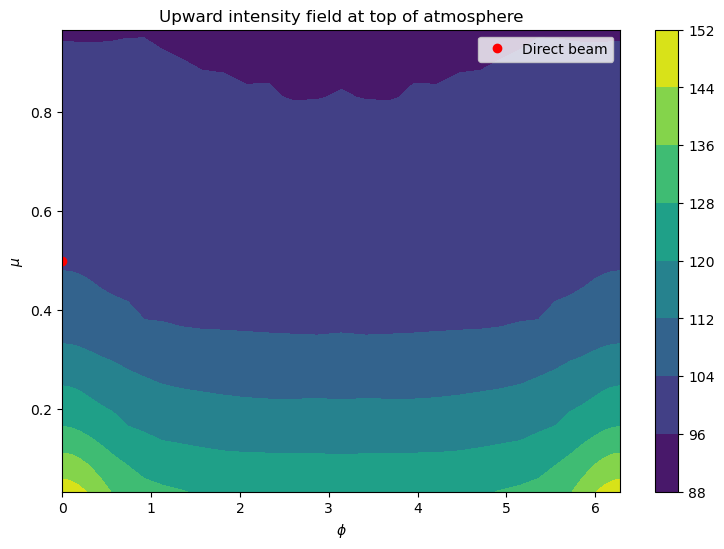

In [51]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

------

<!--bibtex

@article{STWLE2000,
author = {Tsay, Si-Chee and Stamnes, Knut and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco},
year = {2000},
month = {02},
pages = {},
title = {General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT}
}

@inbook{Hap1993, place={Cambridge}, series={Topics in Remote Sensing}, title={The bidirectional reflectance of a semiinfinite medium}, booktitle={Theory of Reflectance and Emittance Spectroscopy}, publisher={Cambridge University Press}, author={Hapke, Bruce}, year={1993}, pages={181–235}, collection={Topics in Remote Sensing}}

-->

# References

<a id="cite-Hap1993"/><sup><a href=#ref-1>[^]</a></sup>Hapke, Bruce. 1993. _The bidirectional reflectance of a semiinfinite medium_.

<a id="cite-STWLE2000"/><sup><a href=#ref-2>[^]</a></sup>Tsay, Si-Chee and Stamnes, Knut and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco. 2000. _General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT_.

